# TP3 SYSTEME DE VERIFICATION DU LOCUTEUR
NOM - PRÉNOM :

Déposer le notebook sur moodle à la fin de la séance.

In [33]:
############################################
# BE : Système de vérification du locuteur #
############################################

import numpy as np
from math import floor
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as em


### 1-DONNÉES à TRAITER

In [34]:
# Écrire une fonction « lecture » permettant de lire un fichier son (en normalisant les échantillons 
# entre -1 et 1, grâce au nombre de bits de quantification), de connaître sa fréquence d’échantillonnage 
# et sa durée. Le nombre de bits de quantification de nos fichiers est 16.
def lecture(fichier, nb_bits):
    f, signal = wav.read(fichier) # renvoie des signaux reels
    sig_norm = signal / (2**(nb_bits-1)-1) # on normalise les signaux
    return sig_norm, f, len(sig_norm)*1/f

### 2-DECOMPOSITION PAROLE/NON-PAROLE

Lire et comprendre la fonction « energie » permettant de calculer l’énergie à court terme
d’un signal en fonction de la taille des fenêtres d’analyse. Ce traitement a été vu lors de
l’Introduction au Son en 1A.
==> La sortie sera booléenne « 0 » (ou « False ») en l’absence de parole et de « 1 » (ou
« True ») en présence de parole.

In [15]:
# Calcul de l'ENERGIE d'un signal
def calcul_energie(signal, taille_fenetre):
    # Initialisation du vecteur résultat
    recouvrement = floor(taille_fenetre / 2)
    nb_fen = floor((np.size(signal) - taille_fenetre) / recouvrement) + 1
    nrj_res = np.zeros(nb_fen)

    # Calcul de l’énergie
    for fen in range(nb_fen):
        p = fen * recouvrement
        nrj_res[fen] = np.sum((signal[p:p + taille_fenetre]) ** 2) / taille_fenetre

    return nrj_res

# Ecrire une fonction « etiquetage » (utilisant la fonction « energie » fournie) permettant
# d’étiqueter un fichier son en parole et non-parole. Le seuil est à fixer par vos soins. 

# ETIQUETAGE en parole/non-parole (1/0) grâce au calcul d'énergie

def etiquetage(signal, taille_fenetre, seuil):
    nrj = calcul_energie(signal, taille_fenetre)
    etiquette = []
    for energie in nrj:
        if energie > seuil:
            etiquette.append(1)
        else:
            etiquette.append(0)
    return etiquette

Tester les fonctions lecture, energie et etiquetage dans les parties de code ci-dessous appliquée à un seul fichier L1_fic1.wav. Décommenter les lignes nécessaires. 

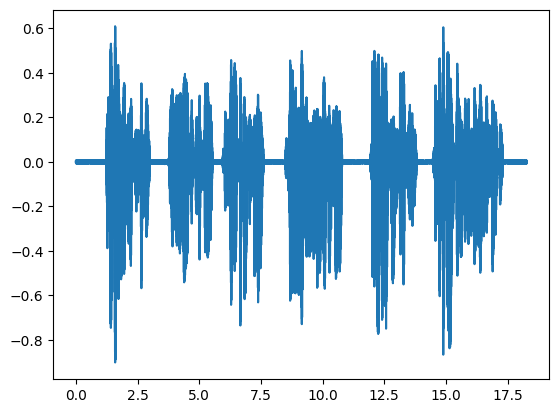

Fe = 20000 Hz et durée = 18.2784 s


In [16]:
#######################
# PROGRAMME PRINCIPAL #
#######################

# Constantes
taille_fenetre = 1024
nb_locuteur = 10
nb_fic_app = 8
seuil = 0.0001
q = 16
nb_MFCC = 8
locuteur_cible = 1
nbe_gauss = 1

# Lecture d'un fichier
signal, fe, duree = lecture('APP/L1_fic1.wav', q)

# Affichage du signal audio et des valeurs
plt.figure(1)
plt.plot(np.arange(len(signal)) / fe, signal)
plt.show()
print('Fe =', fe, 'Hz et durée =', duree, 's')



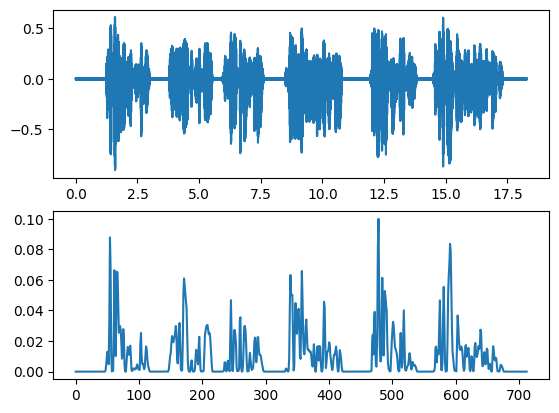

In [17]:
# Calcul de l'énergie d'un fichier
nrj_res = calcul_energie(signal, taille_fenetre)

# Affichage du signal et de l'énergie
plt.figure(2)
plt.subplot(211)
plt.plot(np.arange(len(signal)) / fe, signal)
plt.subplot(212)
plt.plot(nrj_res)
plt.show()


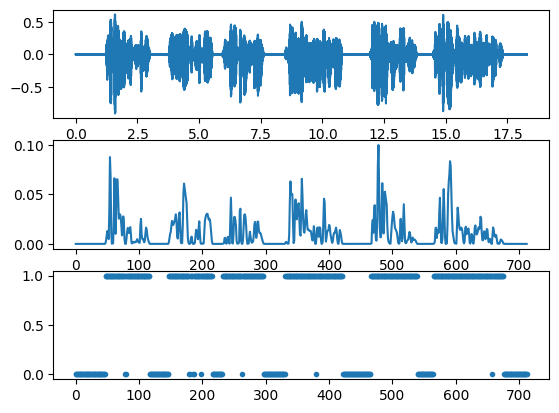

In [18]:
# Etiquetage d'un fichier
etiq = etiquetage(signal, taille_fenetre, seuil)

# Affichage du signal et de l'énergie
plt.figure(3)
plt.subplot(311)
plt.plot(np.arange(len(signal)) / fe, signal)
plt.subplot(312)
plt.plot(nrj_res)
plt.subplot(313)
plt.plot(etiq, '.')
plt.show()


In [23]:
# Ecrire une fonction « etiquetage_total » (utilisant la fonction « etiquetage ») permettant
# d’étiqueter en parole/non-parole tous les fichiers sonores du répertoire « APP ». 

# Les résultats de la fonction « etiquetage » seront enregistrés dans des fichiers texte (avec la
# fonction Numpy savetxt) portant le nom des fichiers son de départ avec l’extension « .lab » et
# seront rangés dans le répertoire « LABELS ». Ce répertoire sera au même niveau que le
# répertoire « WAV ».
 
# ETIQUETAGE_TOTAL --> tous les fichiers du répertoire ont un fichier .lab correspondant
def etiquetage_total(nb_bits, taille_fenetre, nbe_loc, nbe_fic, seuil):
    for i in range(1,nbe_loc+1):
        for j in range(1,nbe_fic+1):
            nom = "L" + str(i) +"_fic" + str(j)
            signal, fe, duree = lecture("APP/"+ nom + ".wav", nb_bits)
            etiquette = etiquetage(signal,taille_fenetre,seuil)
            np.savetxt("LABELS/" + nom + ".lab",etiquette)

Tester la fonction etiquetage_total dans la partie de code ci-dessous. Décommenter les lignes nécessaires. Affiher le contenu du répertoire LABELS

In [25]:
# Géréraliser les traitements précédents 

# Etiquetage des fichiers du repertoire APP
etiquetage_total(q, taille_fenetre, nb_locuteur, nb_fic_app, seuil)


### 3- PARAMETRISATION

In [26]:
# Calcul de "nbe_coef" coefficients cepstraux
def parametrisation(signal, taille_fenetre, nbe_coef):
    # Initialisation de la matrice résultat
    recouvrement = floor(taille_fenetre / 2)
    nb_fen = floor((np.size(signal) - taille_fenetre) / recouvrement) + 1
    mfcc = np.zeros((nb_fen, nbe_coef))

    # Calcul des MFCC
    for fen in range(nb_fen):
        p = fen * recouvrement
        spectre = abs(np.fft.fft(np.multiply(signal[p:p + taille_fenetre], np.hamming(taille_fenetre))))
        cepstre = np.fft.fft(np.log(spectre))
        cc = cepstre[1:nbe_coef+1].real
        mfcc[fen, :] = cc

    return mfcc

Lire et comprendre la fonction « parametrisation ». Là aussi, ce traitement a été vu lors de
l’Introduction au Son en 1A. Le résultat de cette paramétrisation est un fichier composé d’une
suite de valeurs telles : Coef1 Coef2 … Coefnbe_coef

In [27]:
# Écrire une fonction « parametrisation_total.m » (utilisant la fonction « parametrisation »
# fournie) permettant de calculer les MFCC pour tous les fichiers du répertoire « APP ».

# Fonction de PARAMETRISATION_TOTALE --> tous les fichiers du répertoire ont un .mfcc correspondant
def parametrisation_total(nb_bits, taille_fenetre, nbe_coef, nbe_loc, nbe_fic):
    for i in range(1,nbe_loc+1):
        for j in range(1,nbe_fic+1):
            nom = "L" + str(i) +"_fic" + str(j)
            signal, fe, duree = lecture("APP/"+ nom + ".wav", nb_bits)
            mfcc = parametrisation(signal,taille_fenetre,nbe_coef)
            np.savetxt("MFCC/" + nom + ".mfcc",mfcc)

Tester la fonction parametrisation_total dans la partie de code ci-dessous. Décommenter les lignes nécessaires. Afficher le contenu du répertoire MFCC

In [28]:
# Géréraliser les traitements précédents 

# Paramétrisation des fichiers du repertoire APP
parametrisation_total(q, taille_fenetre, nb_MFCC, nb_locuteur, nb_fic_app)

### 4) APPRENTISSAGE

In [29]:
# Affectation des coefficients cepstraux du répertoire "MFCC" suivant les labels
def affectation(REP_LAB, REP_MFCC, nbe_coef, nbe_loc, nbe_fic, locuteur):
    # Initialisation de "param" (MFCC du "monde")
    param = np.empty((0, nbe_coef))

    # Boucle sur tous les fichiers
    for x in range(1, nbe_loc+1):
        # Initialisation de "param_indices" (MFCC du "locuteur")
        param_loc = np.empty((0, nbe_coef))

        for y in range(1, nbe_fic+1):
            # Nom des fichiers LAB et MFCC
            fichier_lab = REP_LAB + '/L' + str(x) + '_fic' + str(y) + '.lab'
            fichier_mfcc = REP_MFCC + '/L' + str(x) + '_fic' + str(y) + '.mfcc'

            # Lecture des 2 fichiers
            lab = np.loadtxt(fichier_lab)
            mfcc = np.loadtxt(fichier_mfcc)

            # Vérification des fichiers
            if np.shape(lab)[0] != np.shape(mfcc)[0]:
                print('Les fichiers ont des tailles différentes', np.shape(lab)[0], np.shape(mfcc)[0])

            # Récupération des labels à 1
            indices = lab == 1

            # Concaténation des MFCC correspondant aux labels à 1
            mfcc_val = mfcc[indices, :]
            param_loc = np.concatenate((param_loc, mfcc_val))

        # Test sur le numéro du locuteur
        if x == locuteur:
            # Nom du fichier MFCC locuteur
            fichier_loc = REP_MFCC + '/L' + str(x) + '.mfcc'

            # Enregistrement dans un fichier texte des MFCC pour le modèle "locuteur"
            np.savetxt(fichier_loc, param_loc, fmt='%f')

        # Concaténation des MFCC du locuteur "x" aux autres
        param = np.concatenate((param, param_loc))

    # Enregistrement dans un fichier texte des MFCC pour le modèle "monde"
    np.savetxt('MFCC/monde.mfcc', param, fmt='%f')

Utiliser et comprendre la fonction « affectation » permettant de créer deux fichiers contenant
l’ensemble des paramètres (MFCC) indicés nécessaire (1) à l’apprentissage des modèles du
« monde » et (2) du « locuteur ». Le choix (numéro) du locuteur est passé en paramètre.

Faire 2 appels à la fonction nommée « em » dans la partie du programme principal dédiée à l'apprentissage. Vous utiliserez la méthode « fit » afin de créer les 2 modèles (« monde » et « Lx »). 

Pour plus de détails, voir :
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

Cette fonction « em » utilisera les vecteurs de données à traiter (paramètres indicés parole
dans un cas et locuteur dans l’autre cas) ainsi que le nombre de lois gaussiennes. Elle fournira
en sortie les modèles du monde et du locuteur représentés par les poids (.weights_), les
moyennes (.means_) et les variances (.covariances_) de chacune des lois gaussiennes.

Tester la partie apprentissage dans la suite du programme principal en décommentant et en complétant le code du programme principal ci-après. 
- Affectation des mfcc des zones de parole pour constitution du modèle de monde et du modèle du locuteur cible. Ne doit être exécuté qu'une seule fois par locuteur cible.
- Apprentissage du modèle du monde 
- Apprentissage du modèle du locuteur cible

In [87]:

#################
# APPRENTISSAGE #
#################

# Affectation
affectation('LABELS', 'MFCC', nb_MFCC, nb_locuteur, nb_fic_app, 3)

# EM (appelant VQ) pour le modèle du "monde"
d_monde = np.loadtxt('MFCC/monde.mfcc')
monde = em(covariance_type='diag')
monde.fit(d_monde)
#------------------------------------------------------------> A compléter...
#print(monde.weights_, monde.means_, monde.covariances_)

# EM (MAP) pour le modèle du "locuteur"
d_locuteur = np.loadtxt('MFCC/L'+ str(3) +'.mfcc')
#-----------------------------------------------------------> A compléter...
Lx = em(weights_init=monde.weights_, means_init=monde.means_,covariance_type='diag')
Lx.fit(d_locuteur)

#print(Lx.weights_, Lx.means_, Lx.covariances_)

GaussianMixture(covariance_type='diag',
                means_init=array([[538.98056785, 137.59306744, 111.07474419, -27.27231334,
        142.53792121,  27.1646045 ,  55.07028739,  -2.29449421]]),
                weights_init=array([1.]))

    ### 5) RECONNAISSANCE

Ecrire la fonction « tests_total » permettant d’effectuer la reconnaissance des fichiers sons
inconnus situés dans le répertoire « WAV/RECO ». Cette fonction prendra en entrée la taille
de la fenêtre d’analyse, le nombre de coefficients cepstraux ainsi que les modèles, composés de
mélanges de lois gaussiennes. Elle fournira en sortie le taux de reconnaissance de chacun des
fichiers.


In [88]:
# Tests sur tous les fichiers du répertoire 'WAV/RECO'
def tests_total(nbe_loc, nb_fic, nb_bits, taille_fenetre, nbe_coef, monde, loc, seuil):
    dico={}
    for i in range(1, nbe_loc+1):
        for j in range(nb_fic):
            nom = "L" + str(i) +"_fic" + str(9+j)
            signal, fe, duree = lecture("RECO/"+ nom + ".wav", nb_bits)
            mfcc = parametrisation(signal, taille_fenetre, nbe_coef)

            mp = monde.score_samples(mfcc)
            lp = loc.score_samples(mfcc)

            vote = mp-lp
            vraissemblance = len(vote[vote<0])/len(vote)

            dico[nom]=vraissemblance

    return dico

Tester la partie reconnaissance dans la suite du programme principal en décommentant et en complétant la partie de code ci-après

In [89]:

#################
# RECONNAISSANCE #
#################

# Tests sur tous les fichiers du répertoire RECO
# Appel de la fonction tests_total ---------------------> A compléter
dic = tests_total(10,2,q, taille_fenetre,nb_MFCC,monde,Lx,seuil)
print(dic)


{'L1_fic9': 0.3466666666666667, 'L1_fic10': 0.29626253418413856, 'L2_fic9': 0.3559096945551129, 'L2_fic10': 0.368575624082232, 'L3_fic9': 0.6547725245316681, 'L3_fic10': 0.5986787778695293, 'L4_fic9': 0.328884652049571, 'L4_fic10': 0.31792376317923765, 'L5_fic9': 0.3704020530367836, 'L5_fic10': 0.3802612481857765, 'L6_fic9': 0.5110851808634772, 'L6_fic10': 0.4489990467111535, 'L7_fic9': 0.24830393487109906, 'L7_fic10': 0.30354131534569984, 'L8_fic9': 0.38930163447251115, 'L8_fic10': 0.3372681281618887, 'L9_fic9': 0.2686935086277732, 'L9_fic10': 0.29880478087649404, 'L10_fic9': 0.4251968503937008, 'L10_fic10': 0.35991605456453307}


In [73]:
### 6) ANALYSE DES DONNÉES

In [ ]:
Comment interprétez-vous les résultats obtenus ? Commentez. 